# How to make a dataset

### Raw data
- CSI: already converted into .npy, without remove_sm
- CSI timestamps: already calibrated against local time
- bag: raw bag file
- local timestamps: standard time linking CSI and images

### Export images
- Use BagLoader to save images and camera timestamps as .npy
- Specify the number of frames
- Specify the resolution
- camera timestamps: to be calibrated against local time
- images: apply depth mask with a certain threshold value

### Export CSI
- Use MyDataMaker
- pycsi.MyConfigs needed (concerning tx_rate=0x1c113 and ntx=3)
- Extract dynamic components of CSI (dividing tx and highpass filter)
- Use convert_img() to threshold and normalize depth images
- Use export_data() to find matching CSI versus images (Specify the CSI length & aligning 'head' or 'tail' & apply savgol_filter on CSI)
- Use deoverlap() to remove samples that have overlapping CSI
- Use slice_by_label() to trim unlabeled parts and regroup into segments
- Use assemble() to assemble multiple samples into one (if needed)
- Use save_dataset() to save the data

### Calculate Bounding Boxes
- Requiring 226 * 128 images
- Use ImageGen
- Use bounding_box() to calculate bounding boxes and average depth value
- Use align_to_center() to make the bounded subject at the center of 128 * 128 images, with zero-padding
- Use convert_bbx() to normalize bounding boxes and adjust the order into '(x1, y1, x2, y2)'
- No need to normalize depth values because the images are already normalized
- Use save() to save the bounding boxes and depth values

### Calculate Phase Differences

### Regroup dataset
- Use Regrouper
- Use load() to load all the modalities (Specify unit shape)
- Use Regroup() to regroup and save same kind of modalities

### Divide dataset
- Use DataSplitter
- Use split() to split train, valid, test data (specify train_ratio and valid_ratio)

# Chechpoint

### Spec

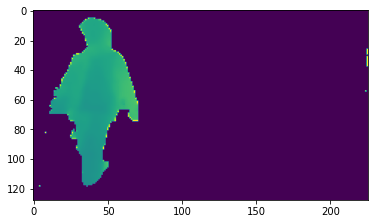

(38, 1, 4)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
imgs = np.load('../dataset/0509/make16_100/01_rimg_asmb1_len100_img.npy', mmap_mode='r')
img = np.squeeze(imgs[100])
plt.imshow(img)
plt.show()
#times = np.load('../sense/0509/raw128_128/01_camtime.npy', mmap_mode='r')
#print(times.shape)
#print(times[:100] - 1.68362387e+09)
depth = np.load('../dataset/0509/make16_900-few/bbx_train.npy')
#print(depth[99:120])
print(depth.shape)
#depth[depth>3000] = 3000
#depth /= 3000.
#np.save('../dataset/0509/make15-split/depth_test.npy', depth)

### Export Images

Setting camera stream...Done
Starting exporting image...
Setting camera stream...Done


  0%|          | 0/5400 [00:00<?, ?it/s]

Calibrating camera time against local time file...Done
lag=-0.06508312516742283
Masking...


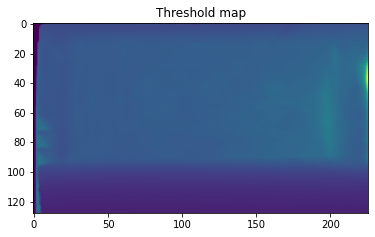

  0%|          | 0/5400 [00:00<?, ?it/s]

Done
Saving...Done
Setting camera stream...Done
Starting exporting image...
Setting camera stream...Done


  0%|          | 0/5000 [00:00<?, ?it/s]

Calibrating camera time against local time file...Done
lag=-0.10003251504898071
Masking...


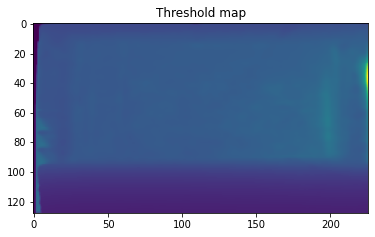

  0%|          | 0/5000 [00:00<?, ?it/s]

Done
Saving...Done
Setting camera stream...Done
Starting exporting image...
Setting camera stream...Done


  0%|          | 0/5100 [00:00<?, ?it/s]

Calibrating camera time against local time file...Done
lag=-0.13225088638417862
Masking...


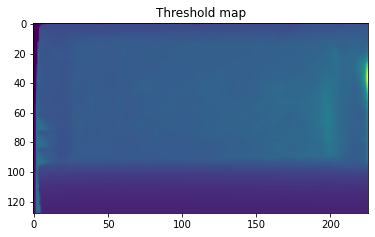

  0%|          | 0/5100 [00:00<?, ?it/s]

Done
Saving...Done
Setting camera stream...Done
Starting exporting image...
Setting camera stream...Done


  0%|          | 0/5100 [00:00<?, ?it/s]

Calibrating camera time against local time file...Done
lag=-0.09882854569192026
Masking...


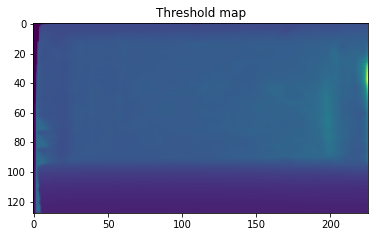

  0%|          | 0/5100 [00:00<?, ?it/s]

Done
Saving...Done


In [93]:
%matplotlib inline
import make_dataset_v03 as md
subs = [
    ('01', 5400),
    ('02', 5000),
    ('03', 5100), 
    ('04', 5100)
]
for (sub, length) in subs:
    bagloader = BagLoader(length, f"../sense/0509/{sub}.bag", f"../sense/0509/{sub}_timestamps.txt", img_shape=(226, 128))
    bagloader.export_images()
    bagloader.depth_mask(0.7)
    bagloader.save_images(f"../sense/0509/raw226_128/")

### Export CSI

In [17]:
%matplotlib inline
import make_dataset_v03 as md
import pycsi
subs = [
    ('01', 5400),
    ('02', 5000),
    ('03', 5100), 
    ('04', 5100)
]

configs = pycsi.MyConfigs()
configs.tx_rate = 0x1c113
configs.ntx = 3

for (name, length) in subs:
    mkdata = MyDataMaker(csi_configs=configs, img_shape=(226, 128), csi_shape=(2, 900, 30, 3), total_frames=length, assemble_number=1,
                        img_path = f"../sense/0509/raw226_128/{name}_img.npy",
                        camera_time_path = f"../sense/0509/raw226_128/{name}_camtime.npy",
                        csi_path = f"../npsave/0509/0509A{name}-csio.npy",
                        label_path = f"../sense/0509/{name}_labels.csv",
                        save_path = f"../dataset/0509/make16_900/")
    mkdata.jupyter = True
    mkdata.csi.extract_dynamic(mode='overall-divide', ref='tx', ref_antenna=1)
    mkdata.csi.extract_dynamic(mode='highpass')
    mkdata.convert_img()
    mkdata.export_data(filter=True, alignment='tail')
    mkdata.deoverlap()
    mkdata.slice_by_label()
    mkdata.assemble()
    mkdata.save_dataset(name + '_rimg', 'img')
    mkdata.save_dataset(name + '_dyn', 'csi', 'time', 'csi_ind', 'label')

Loading IMG...
 Loaded images of (5400, 128, 226) as float64
CSI npy load start... Mon Apr 15 12:30:48 2024
loaded
scaled
Removing sm...Done
CSI (186643, 30, 3, 3) load complete Mon Apr 15 12:31:41 2024
Loading label...Done
CSI apply dynamic component extraction: overall-divide versus tx1...Done
CSI apply dynamic component extraction: highpass versus rx0...Done
Converting IMG...Done
Starting exporting data...


  0%|          | 0/5400 [00:00<?, ?it/s]

Deopverlapping...Done
Slicing 48 segments...
 Segment 0 start=10, end=10
 Segment 1 start=14, end=15
 Segment 2 start=15, end=16
 Segment 3 start=19, end=21
 Segment 4 start=21, end=22
 Segment 5 start=26, end=27
 Segment 6 start=27, end=28
 Segment 7 start=32, end=33
 Segment 8 start=36, end=38
 Segment 9 start=38, end=41
 Segment 10 start=42, end=44
 Segment 11 start=45, end=47
 Segment 12 start=48, end=50
 Segment 13 start=51, end=54
 Segment 14 start=54, end=57
 Segment 15 start=57, end=60
 Segment 16 start=61, end=64
 Segment 17 start=64, end=67
 Segment 18 start=71, end=73
 Segment 19 start=74, end=76
 Segment 20 start=77, end=79
 Segment 21 start=80, end=82
 Segment 22 start=84, end=86
 Segment 23 start=86, end=89
 Segment 24 start=90, end=92
 Segment 25 start=93, end=95
 Segment 26 start=96, end=98
 Segment 27 start=99, end=102
 Segment 28 start=105, end=107
 Segment 29 start=107, end=110
 Segment 30 start=111, end=113
 Segment 31 start=114, end=116
 Segment 32 start=117, end=1

  0%|          | 0/5000 [00:00<?, ?it/s]

Deopverlapping...Done
Slicing 29 segments...
 Segment 0 start=5, end=7
 Segment 1 start=11, end=14
 Segment 2 start=14, end=16
 Segment 3 start=21, end=23
 Segment 4 start=24, end=25
 Segment 5 start=31, end=33
 Segment 6 start=36, end=40
 Segment 7 start=41, end=46
 Segment 8 start=47, end=51
 Segment 9 start=52, end=57
 Segment 10 start=58, end=63
 Segment 11 start=64, end=69
 Segment 12 start=72, end=77
 Segment 13 start=77, end=82
 Segment 14 start=83, end=88
 Segment 15 start=88, end=93
 Segment 16 start=94, end=98
 Segment 17 start=99, end=104
 Segment 18 start=108, end=113
 Segment 19 start=113, end=118
 Segment 20 start=120, end=125
 Segment 21 start=126, end=131
 Segment 22 start=133, end=137
 Segment 23 start=138, end=144
 Segment 24 start=148, end=151
 Segment 25 start=157, end=160
 Segment 26 start=163, end=165
 Segment 27 start=171, end=174
 Segment 28 start=177, end=179
Done
Aligning...Done
Saving...Done
Saving...Done
Loading IMG...
 Loaded images of (5100, 128, 226) as f

  0%|          | 0/5100 [00:00<?, ?it/s]

Deopverlapping...Done
Slicing 36 segments...
 Segment 0 start=4, end=7
 Segment 1 start=8, end=12
 Segment 2 start=13, end=17
 Segment 3 start=18, end=22
 Segment 4 start=23, end=27
 Segment 5 start=28, end=32
 Segment 6 start=33, end=36
 Segment 7 start=38, end=42
 Segment 8 start=43, end=47
 Segment 9 start=48, end=52
 Segment 10 start=54, end=57
 Segment 11 start=59, end=63
 Segment 12 start=65, end=68
 Segment 13 start=70, end=73
 Segment 14 start=76, end=78
 Segment 15 start=81, end=83
 Segment 16 start=86, end=88
 Segment 17 start=91, end=93
 Segment 18 start=96, end=99
 Segment 19 start=101, end=104
 Segment 20 start=107, end=110
 Segment 21 start=112, end=115
 Segment 22 start=118, end=120
 Segment 23 start=123, end=126
 Segment 24 start=129, end=131
 Segment 25 start=134, end=136
 Segment 26 start=139, end=140
 Segment 27 start=143, end=145
 Segment 28 start=148, end=149
 Segment 29 start=152, end=153
 Segment 30 start=157, end=158
 Segment 31 start=162, end=163
 Segment 32 st

  0%|          | 0/5100 [00:00<?, ?it/s]

Deopverlapping...Done
Slicing 21 segments...
 Segment 0 start=4, end=9
 Segment 1 start=12, end=17
 Segment 2 start=20, end=25
 Segment 3 start=28, end=32
 Segment 4 start=35, end=41
 Segment 5 start=43, end=49
 Segment 6 start=53, end=59
 Segment 7 start=62, end=68
 Segment 8 start=72, end=78
 Segment 9 start=80, end=86
 Segment 10 start=89, end=94
 Segment 11 start=98, end=102
 Segment 12 start=106, end=111
 Segment 13 start=114, end=119
 Segment 14 start=124, end=129
 Segment 15 start=132, end=137
 Segment 16 start=143, end=146
 Segment 17 start=152, end=155
 Segment 18 start=162, end=164
 Segment 19 start=171, end=174
 Segment 20 start=180, end=183
Done
Aligning...Done
Saving...Done
Saving...Done


### Calculate Bounding Boxes

In [18]:
import manipulate_image as mi
names = ('01', '02', '03', '04')
for name in names:
    gen = mi.ImageGen(name, bbx_order='xyxy')
    gen.load_images(f"../dataset/0509/make16_900/{name}_rimg_asmb1_len900_img.npy")
    gen.bounding_box(min_area=0, show=False)
    gen.align_to_center(unified_size=True)
    gen.convert_bbx()
    #gen.print_len()
    gen.save('../dataset/0509/make16_900-resize/', save_terms={'raw_bbx', 'gen_img', 'depth'})
    #gen.view_generation()

01 loading images...
Loaded img of (87, 1, 128, 226) as float64
Labeling bounding boxes...Complete!
Starting exporting image...


100% 87/87 [00:00<00:00, 714.59it/s]

Generation complete!
Converting bbx...Done
Saving...
Saved raw_bbx
Saved depth


Saved gen_img
All saved!
02 loading images...
Loaded img of (112, 1, 128, 226) as float64
Labeling bounding boxes...Complete!
Starting exporting image...


100% 112/112 [00:00<00:00, 529.12it/s]


Generation complete!
Converting bbx...Done
Saving...
Saved raw_bbx
Saved depth
Saved gen_img
All saved!
03 loading images...
Loaded img of (92, 1, 128, 226) as float64
Labeling bounding boxes...Complete!
Starting exporting image...


100% 92/92 [00:00<00:00, 665.14it/s]

Generation complete!
Converting bbx...Done
Saving...
Saved raw_bbx
Saved depth


Saved gen_img
All saved!
04 loading images...
Loaded img of (98, 1, 128, 226) as float64
Labeling bounding boxes...Complete!
Starting exporting image...


100% 98/98 [00:00<00:00, 615.96it/s]

Generation complete!
Converting bbx...Done
Saving...


Saved raw_bbx
Saved depth
Saved gen_img
All saved!


### Regroup

In [19]:
import manipulate_dataset as mp

In [20]:
names = ('01', '02', '03', '04')
reg = mp.Regrouper(
    '../dataset/0509/make16_900/',
    '../dataset/0509/make16_900-finished/',
    names,
    {'img': (1, 128, 226),
     'csi': (6, 30, 900),
     'time': (1, 1)
     }
)
reg.load()
reg.regroup(img='r_', csi='f_')

Loading ('01', '02', '03', '04')...
 Loaded 01_rimg_asmb1_len900_img.npy of (87, 1, 128, 226)
 Loaded 01_dyn_asmb1_len900_csi.npy of (87, 6, 30, 900)
 Loaded 01_dyn_asmb1_len900_time.npy of (87, 1, 1)
 Loaded 02_rimg_asmb1_len900_img.npy of (112, 1, 128, 226)
 Loaded 02_dyn_asmb1_len900_csi.npy of (112, 6, 30, 900)
 Loaded 02_dyn_asmb1_len900_time.npy of (112, 1, 1)
 Loaded 03_rimg_asmb1_len900_img.npy of (92, 1, 128, 226)
 Loaded 03_dyn_asmb1_len900_csi.npy of (92, 6, 30, 900)
 Loaded 03_dyn_asmb1_len900_time.npy of (92, 1, 1)
 Loaded 04_rimg_asmb1_len900_img.npy of (98, 1, 128, 226)
 Loaded 04_dyn_asmb1_len900_csi.npy of (98, 6, 30, 900)
 Loaded 04_dyn_asmb1_len900_time.npy of (98, 1, 1)
All loaded!
Saving...
 Saved img of len 389
 Saved csi of len 389
 Saved time of len 389
All saved!


In [21]:
names = ('01', '02', '03', '04')
reg2 = mp.Regrouper(
    '../dataset/0509/make16_900-resize/',
    '../dataset/0509/make16_900-finished/',
    names,
    {'img': (1, 128, 128),
     'bbx': (1, 4),
     'depth': (1, 1)
     }
)
reg2.load()
reg2.regroup(img='c_')

Loading ('01', '02', '03', '04')...
 Loaded 01_xyxy_raw_bbx.npy of (87, 1, 4)
 Loaded 01_depth.npy of (87, 1, 1)
 Loaded 01_gen_img.npy of (87, 1, 128, 128)
 Loaded 02_xyxy_raw_bbx.npy of (112, 1, 4)
 Loaded 02_depth.npy of (112, 1, 1)
 Loaded 02_gen_img.npy of (112, 1, 128, 128)
 Loaded 03_xyxy_raw_bbx.npy of (92, 1, 4)
 Loaded 03_depth.npy of (92, 1, 1)
 Loaded 03_gen_img.npy of (92, 1, 128, 128)
 Loaded 04_xyxy_raw_bbx.npy of (98, 1, 4)
 Loaded 04_depth.npy of (98, 1, 1)
 Loaded 04_gen_img.npy of (98, 1, 128, 128)
All loaded!
Saving...
 Saved img of len 389
 Saved bbx of len 389
 Saved depth of len 389
All saved!


### Split

In [5]:
import manipulate_dataset as mp
import os
datadir = '../dataset/0509/make16_100-finished/'
print(os.listdir(datadir))

['r_img.npy', 'time.npy', 'c_img.npy', 'bbx.npy', 'depth.npy', 'f_csi.npy', '.ipynb_checkpoints']


In [6]:
splitter = mp.DataSplitter(paths = {'r_img': f"{datadir}r_img.npy",
                                    'c_img': f"{datadir}c_img.npy",
                                    'bbx': f"{datadir}bbx.npy",
                                    'f_csi': f"{datadir}f_csi.npy",
                                    'depth': f"{datadir}depth.npy"},
                          save_path = '../dataset/0509/make16_00-few/')
splitter.split(train_ratio=0.1, valid_ratio=0.1)
splitter.save()

Loading...
 Loaded r_img of len 3414 as float64
 Loaded c_img of len 3414 as float64
 Loaded bbx of len 3414 as float64
 Loaded f_csi of len 3414 as float64
 Loaded depth of len 3414 as float64
Splitting. Train size = 341, Valid size = 341, Test size = 2732...Done
Saving...
 Saving r_img...
 Saving c_img...
 Saving bbx...
 Saving f_csi...
 Saving depth...
All saved!


# Workflow

In [ ]:
import make_dataset_v03 as md
import pycsi
import manipulate_dataset as mp
import os
import manipulate_image as mi

subs = [
    ('01', 5400),
    ('02', 5000),
    ('03', 5100), 
    ('04', 5100)
]

data = '0509'
make = 'make16-900'

